In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/muef/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField

### importing data

In [2]:
# import coal data
data_dir = 'data/'
bk = pd.read_csv(data_dir + 'Braunkohlefoerderung.csv', header=1, index_col=0)
sk = pd.read_csv(data_dir + 'Steinkohlefoerderung.csv', header=1, index_col=0)
si = pd.read_csv(data_dir + 'hard coal imports.csv', header=1, index_col=0)

coal_production = pd.merge(bk, sk, left_index=True, right_index=True, how='outer')
# convert from 1000 t to Mt
coal_production = coal_production / 1000
coal_production = pd.merge(coal_production, si, left_index=True, right_index=True, how='outer')

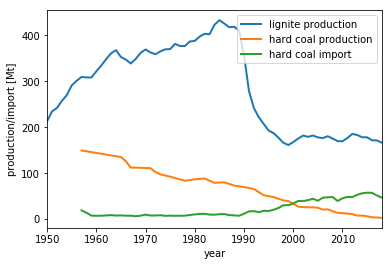

In [3]:
coal_production.interpolate().plot(linewidth=2)

plt.ylabel('production/import [Mt]')

In [4]:
# import classification
run_id = 2350

# map parliamentary periods to dates / years
topic_dir = "plots/topic_analysis_{}/".format(run_id)
topic_classification = pd.read_csv(topic_dir + '0_topic_list_run{}_labeled.csv'.format(run_id), index_col=0)
topic_classification #['classification']

,label,label short,classification,label Finn,Discussion with Jan,Jan,Jan.1,Jan period,top words weighted,top words avg,top words peak,score pct,score
184089,stop words,stop words,procedural and general politics,stopwords,NaN,stop words,NaN,NaN,"tun, wirklich, wiss, red, gar, darub, natur, r...","tun, wiss, wirklich, red, gar, darub, natur, r...","ding, vielleicht, wirklich, gar, wiss, seh, we...",10.672064,419821.116446
184090,procedural,procedural,procedural and general politics,procedural,NaN,procedural,NaN,NaN,"darauf, haus, darub, darf, bereich, punkt, bun...","darauf, darub, haus, bereich, punkt, debatt, b...","haus, darauf, darf, darub, entscheid, lass, bu...",9.348242,367744.157874
184081,economic policy,economic policy,economy and finance,economic policy,NaN,Wirtschaftspolitik/ -entwicklung,NaN,NaN,"wirtschaft, unternehm, entwickl, deutsch, mark...","unternehm, wirtschaft, deutsch, deutschland, m...","wirtschaft, entwickl, bereich, wirtschaftspoli...",5.492435,216063.202495
184105,federal government,federal government,procedural and general politics,procedural 2,NaN,Bundesregierung,Procedere,NaN,"bundeskanzl, partei, regier, deutsch, sozialde...","bundeskanzl, deutsch, partei, deutschland, reg...","regier, bundeskanzl, volk, partei, sozialdemok...",4.037749,158838.262969
184102,policy statements,policy statements,procedural and general politics,economic system ?,NaN,NaN,Grundsatzreden,NaN,"deutsch, volk, bundesregier, freiheit, wirtsch...","deutsch, volk, bundesregier, freiheit, deutsch...","deutsch, deutschland, gemeinsam, wirtschaft, f...",3.989937,156957.446933
184106,budget,budget,economy and budget,budget,NaN,Haushaltspolitik/ Bundeshaushalt,NaN,1 bis 5/6 - hält sich aber,"milliard, million, bund, haushalt, hoh, rund, ...","milliard, bund, million, hoh, rund, haushalt, ...","million, milliard, bund, haushalt, hoh, bundes...",3.783282,148827.974002
184086,European Coal and Steel Community,ECSC,international and regional,German-French economic policy,NaN,Europäische (Wirtschafts-)gemeinschaft,Deutsch-französische Wirtschaftszusammenarbeit,NaN,"europa, deutsch, vertrag, franzos, frankreich,...","europa, union, gemeinschaft, deutsch, vertrag,...","deutsch, schumanplan, deutschland, vertrag, fr...",3.685528,144982.504003
184098,international cooperation,international cooperation,international and regional,Europe,international,Internationale Politik,Europäische Politk,NaN,"europa, gemeinsam, international, deutschland,...","europa, gemeinsam, international, staat, gemei...","deutschland, wichtig, international, gemeinsam...",3.627137,142685.511866
184108,energy policy,energy policy,energy,energy policy,NaN,Energiepolitik,look at topic score development and explain,NaN,"energi, erneuerbar, energiepolit, kohl, bundes...","energi, erneuerbar, kohl, energiepolit, energi...","energiepolit, bundesregier, energi, kohl, kern...",3.422472,134634.299691
184097,procedural 2,mixed,procedural and general politics,Mixed ?,Gesetzgebung?,Gesetzgebung,EWG highlighted,NaN,"gesetz, wirtschaft, bundesregier, entwurf, bun...","gesetz, wirtschaft, bundesregier, entwurf, bun...","ewg, rechtzeit, gesetz, endgult, wirtschaft, b...",3.160606,124332.949316


# show in plot:

- coal production
- governments (with color)
- number of seats per party?
- policy events
- topic aggregation

In [5]:
run_id = 2350

save_dir = "./plots/topic_analysis_{}".format(run_id)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

dts = DocTopic.objects.filter(run_id=run_id)
# total score of all DocTopics
print(dts.aggregate(
    n = Sum('score')
))
dts.values('topic__title','ut__document__parlperiod__n').annotate(n = Sum('score'))
topic_period_scores = dts.values('topic__title','topic__id', 'ut__document__parlperiod__n').annotate(score = Sum('score'))

{'n': 3933832.44997399}


In [6]:
df = pd.DataFrame.from_dict(topic_period_scores)
df["classification"] = df["topic__id"]
def id_to_class(idn):
    return topic_classification.loc[idn]['classification']
df["classification"] = df["classification"].apply(id_to_class)

dfagg = df.groupby(["classification","ut__document__parlperiod__n"]).sum().drop(columns=["topic__id"])

dfagg = dfagg.unstack().transpose().droplevel(0)
dfagg

classification,economy and budget,economy and finance,energy,environment,international and regional,procedural and general politics
ut__document__parlperiod__n,,,,,,
1,76990.733805,19527.988686,43716.125139,7180.540922,105030.479370,98545.882078
2,51646.639410,24322.678377,49790.459443,12680.437822,41795.781700,81019.103249
3,52406.103351,17077.986502,42610.515107,6849.205053,11345.719742,56210.270245
4,30239.743760,12161.850947,30864.390314,7996.826921,12503.080281,49579.707777
5,66953.556323,27829.584234,42669.275794,10452.604316,17737.163158,110350.916174
6,20448.086603,3389.087215,5879.739389,1966.289240,3039.577704,27939.169849
7,42434.272297,11545.858097,42829.870332,1944.140813,8718.787481,74122.320980
8,47581.648721,16766.369416,72108.223514,7037.098159,14926.956429,97765.703761
9,40173.559201,10582.879805,27207.168094,2953.287637,10089.323837,67656.281425


In [7]:
party_color_map = {'spd': "#0088FF", 'cducsu': "#222222", 'fdp': "#FFED00",
                   'gruene': "#64A12D", 'linke': "#8C3473", 'spd': "#EB001F", 'dp': '#808080'}


In [8]:
gvmt = pd.read_csv(data_dir + 'List of German governments.csv', header=1)
gvmt

,parliamentary period,begin year,end year,Party 1,Party 2,Party 3,chancellor
0,1,1949,1953,cducsu,fdp,dp,Konrad Adenauer
1,2,1953,1957,cducsu,fdp,dp,Konrad Adenauer
2,3,1957,1961,cducsu,dp,NaN,Konrad Adenauer
3,4,1961,1963,cducsu,fdp,dp,Konrad Adenauer
4,4,1963,1965,cducsu,fdp,NaN,Ludwig Erhard
5,5,1965,1966,cducsu,fdp,NaN,Ludwig Erhard
6,5,1966,1969,cducsu,spd,NaN,Kurt Georg Kiesinger
7,6,1969,1972,spd,fdp,NaN,Willy Brandt
8,7,1972,1974,spd,fdp,NaN,Willy Brandt
9,7,1974,1976,spd,fdp,NaN,Helmut Schmidt


In [9]:
mid_years = np.array([1951. , 1955. , 1959. , 1963. , 1967, 1970.5,
                      1974  , 1978. , 1981.5 , 1985. , 1988.5, 1992. ,
                      1996. , 2000. , 2003.5, 2007. , 2011. , 2015. , 2018. ])

In [10]:
def plot_government(ax):
    from matplotlib.patches import Rectangle

    for i in gvmt.index:
        width = gvmt.loc[i]['end year'] - gvmt.loc[i]['begin year']
        rect = Rectangle((gvmt.loc[i]['begin year'], 0.5), width, 0.5, alpha=0.8,
                         edgecolor='k', linewidth=1, facecolor = party_color_map[gvmt.loc[i]['Party 1']]) 
        ax.add_patch(rect)
        rect = Rectangle((gvmt.loc[i]['begin year'], 0), width, 0.5, alpha=0.8,
                         edgecolor='k', linewidth=1, facecolor = party_color_map[gvmt.loc[i]['Party 2']]) 
        ax.add_patch(rect)
    
    ax.set_xlim([1949, 2019])
    ax.set_yticks([])
    ax.grid(False)
    ax.set_ylabel('government\n coalitions')

In [11]:
%matplotlib notebook

# test interpolation:
mid_years_plus = np.array([1949, 1951. , 1955. , 1959. , 1963. , 1967, 1970.5,
                      1974  , 1978. , 1981.5 , 1985. , 1988.5, 1992. ,
                      1996. , 2000. , 2003.5, 2007. , 2011. , 2015. , 2018., 2019 ])

from scipy.interpolate import PchipInterpolator
from scipy.interpolate import Akima1DInterpolator
from scipy.interpolate import interp1d

x_year = np.arange(1949, 2019, 0.1)
y = dfs['energy'].values
y = np.append(y, dfs['energy'].iloc[-1])
y = np.insert(y, 0, dfs['energy'].iloc[0])

# test spline interpolation: cubic, quadratic
interp_func1 = interp1d(mid_years_plus, y, kind='quadratic')

# test Akima Interpolation
interp_func2 = Akima1DInterpolator(mid_years, dfs['energy'].values)

# test PchipInterpolator
interp_func3 = PchipInterpolator(mid_years, dfs['energy'].values)

plt.plot(x_year, interp_func1(interpol_years))
plt.plot(x_year, interp_func2(interpol_years), ':')
plt.plot(x_year, interp_func3(interpol_years), '--')

plt.scatter(mid_years, dfs['energy'], c='r')

NameError: name 'dfs' is not defined

<IPython.core.display.Javascript object>


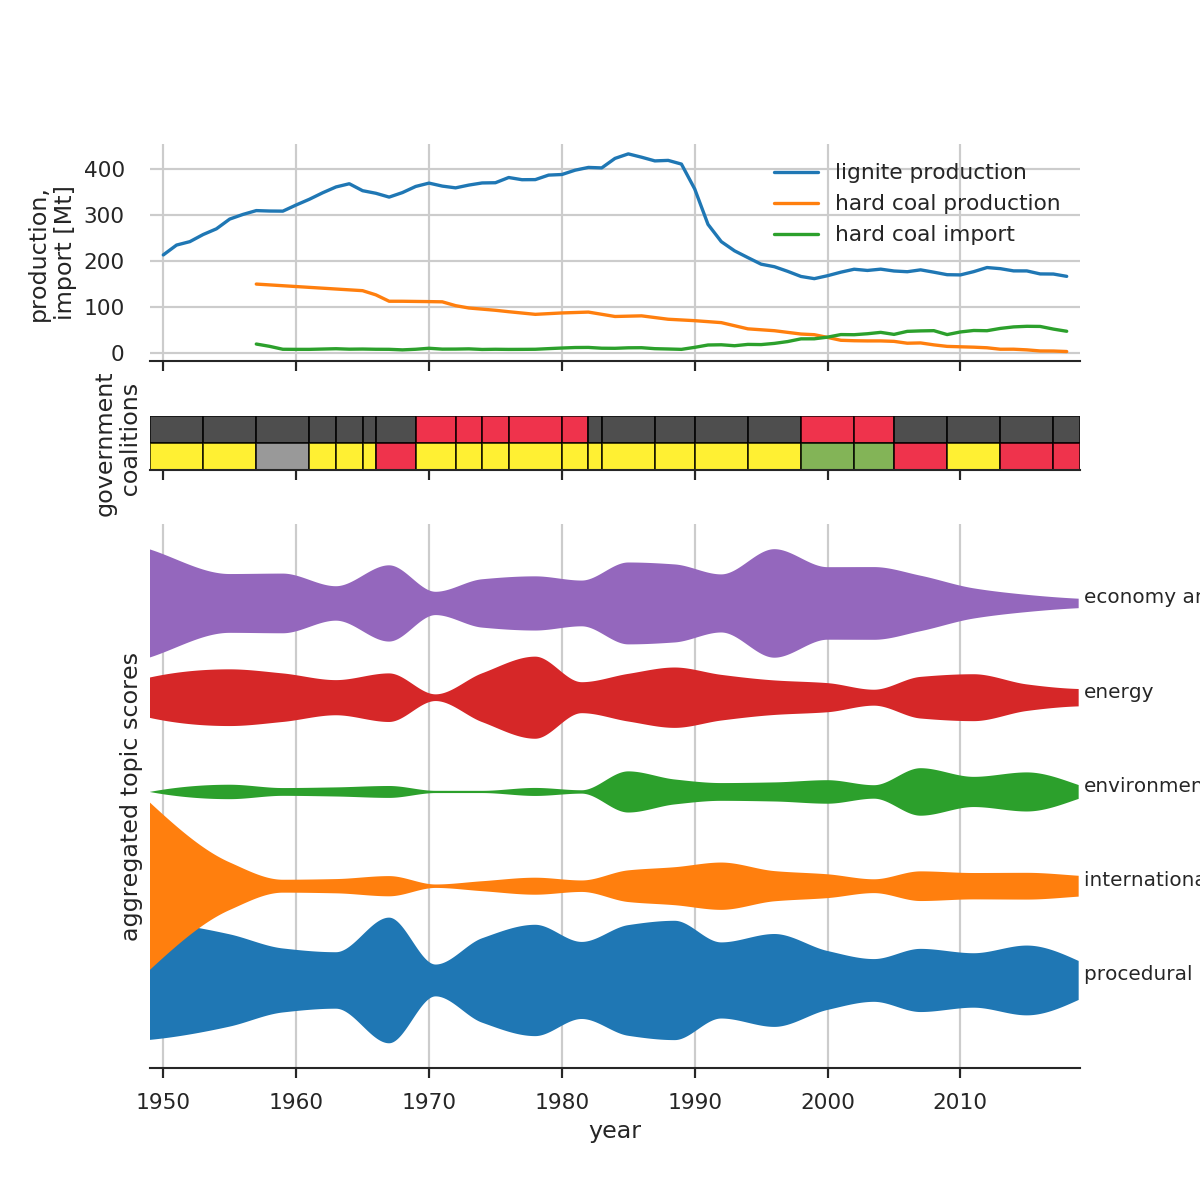

In [12]:
interpolate = True

if interpolate:
    from scipy.interpolate import PchipInterpolator
    x_years = np.arange(1949, 2019, 0.1)

sns.set_context("talk")
sns.set_style("ticks")
sns.set_style({'axes.spines.bottom': True,
               'axes.grid':True,
               'axes.spines.left': False,
               'axes.spines.right': False,
               'axes.spines.top': False,
               'ytick.left': False,
               'figure.facecolor':'w'})

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 10), gridspec_kw={'height_ratios': [2, 0.5, 5]})

# plot coal production

coal_production.interpolate().plot(linewidth=2, ax=ax[0])
ax[0].set_ylabel('production,\nimport [Mt]')

# plot government coalitions
plot_government(ax[1])

# plot aggregate topics
#dfs = dfagg
dfs = dfagg[["economy and budget", "energy", "environment",
             "international and regional", "procedural and general politics"]]

ax[2].set_yticks([])

max_val = 1.5 * dfs.max().max()

for i, t in enumerate(reversed(dfs.columns)):
    if interpolate:
        interp_func = PchipInterpolator(mid_years, dfs[t])

        ax[2].fill_between(x_years, interp_func(x_years) + i*max_val, i*max_val - interp_func(x_years), label=t)
    else:
        ax[2].fill_between(mid_years, dfs[t] + i*max_val, i*max_val - dfs[t], label=t)
    ax[2].text(2019.3, (i+0.) *max_val, t, fontsize=12)

ax[2].set_xlabel('year')
ax[2].set_ylabel('aggregated topic scores')

plt.savefig(os.path.join(save_dir, 'topic_evolution_run{}_aggregate.png'.format(run_id)), dpi=150, bbox_inches="tight")

# overview fig with selected topics

In [13]:
# get topic scores or shares

shares = True

topic_period_scores = dts.values('topic__title','ut__document__parlperiod__n').annotate(score = Sum('score'))

df = pd.DataFrame.from_dict(topic_period_scores)
df.columns = ['score', 'topic', 'parlperiod']
df_scores = df.pivot(index='parlperiod', columns='topic', values='score')
df_scores

# normalization
df_shares = df_scores.copy()
for i in df_shares.index:
    df_shares.loc[i] = df_scores.loc[i] / df_scores.loc[i].sum() * 100
df_shares

# make selection

selection = ['subsidy reduction', 'climate protection', 'energy transition & power market', 'coal mining',
             'environmental protection', 'coal mining']

#df_shares = df_shares[selection]
#df_scores = df_scores[selection]

# sort topics

def get_sorted_columns(df):
    
    # sort according to position of peak
    sel2 = df.copy()
    sel2.loc['peak_pos'] = [sel2[topic].idxmax() for topic in sel2.columns]
    sel2 = sel2.sort_values(by='peak_pos', axis=1)
    sel2 = sel2.drop('peak_pos')
    return sel2.columns

topic_classes = ['economy and budget', 'energy', 'environment', 'international and regional']

index = pd.Index([])

for topic_class in topic_classes:
    print(topic_class)
    topics_in_class = topic_classification[topic_classification['classification'] == topic_class]['label'].values
    
    #topics_in_class = np.array(list(set(topics_in_class) & set(df_scores.columns)))
    print(topics_in_class)
    if len(topics_in_class) > 1:
        index = index.append(get_sorted_columns(df_scores[topics_in_class]))
    elif len(topics_in_class) == 1:
        index = index.append(pd.Index(topics_in_class))
        
# get color palette
sns.set_palette('husl', 4)
colors = sns.color_palette()

color_dict = {cl: colors[i] for i, cl in enumerate(topic_classes)}

economy and budget
['budget' 'budget 2' 'job market' 'fiscal reform' 'economic policy 2'
 'housing & social security' 'economic policy & participation'
 'subsidy reduction' 'tax policy' 'research & development']
energy
['energy policy' 'energy transition & power market' 'coal policy & prices'
 'hard coal & subsidies' 'transport policy' 'risks of nuclear energy'
 'nuclear phase-out' 'coal mining']
environment
['climate protection' 'environmental protection' 'agricultural policy'
 'green policies' 'natural resources']
international and regional
['European Coal and Steel Community' 'international cooperation'
 'foreign policy' 'reunification' 'structural adjustment']


<IPython.core.display.Javascript object>


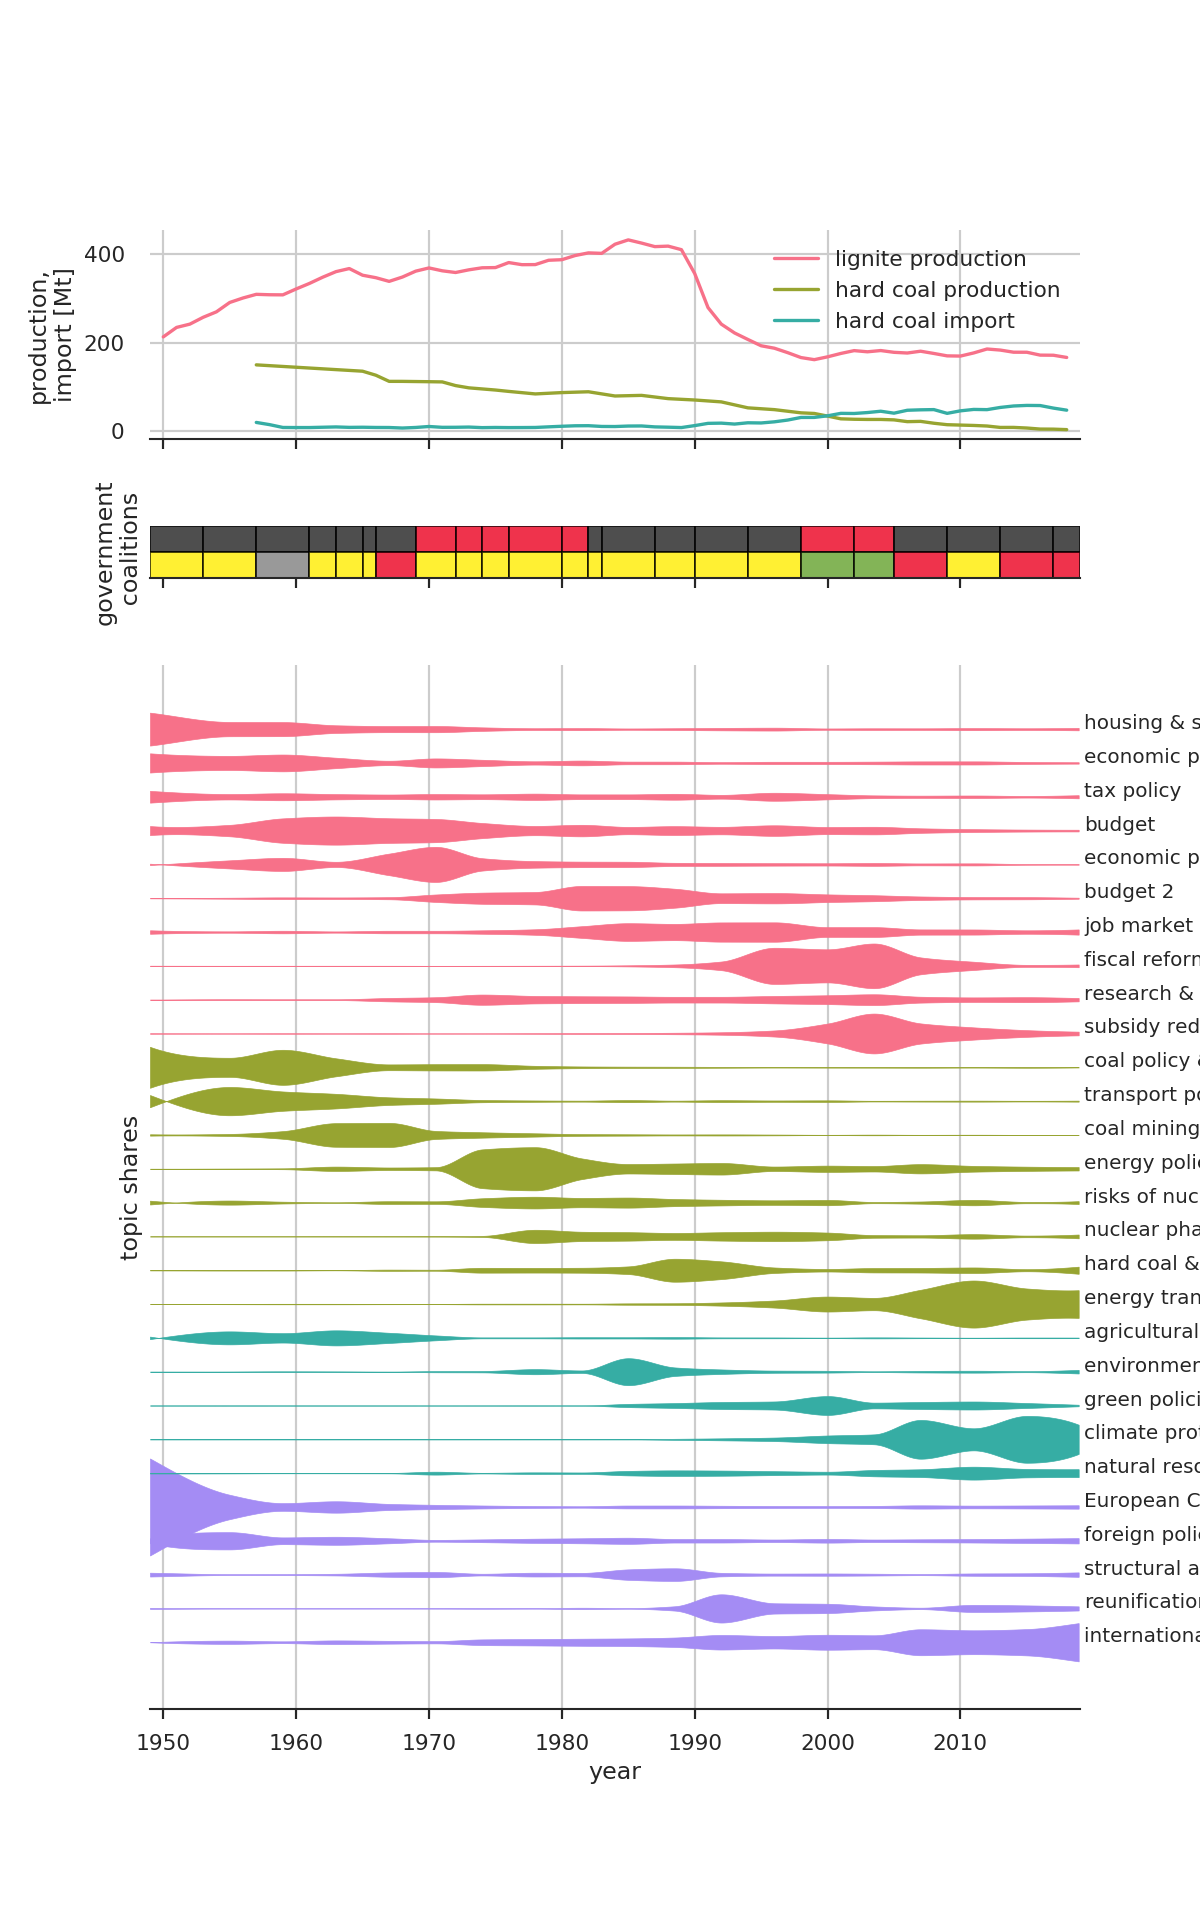

In [14]:
interpolate = True

if interpolate:
    from scipy.interpolate import PchipInterpolator
    x_years = np.arange(1949, 2019, 0.1)

sns.set_context("talk")
sns.set_style("ticks")
sns.set_style({'axes.spines.bottom': True,
               'axes.grid':True,
               'axes.spines.left': False,
               'axes.spines.right': False,
               'axes.spines.top': False,
               'ytick.left': False})

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 16),
                       gridspec_kw={'height_ratios': [2, 0.5, 10]})

# plot coal production

coal_production.interpolate().plot(linewidth=2, ax=ax[0])
ax[0].set_ylabel('production,\nimport [Mt]')

# plot government coalitions
plot_government(ax[1])

# plot selected topics
dfs = df_shares

ax[2].set_yticks([])

max_val = 1. * dfs.max().max()

for i, t in enumerate(reversed(index)):
    topic_class = topic_classification[topic_classification['label'] == t]['classification'].values[0]
    
    if interpolate:
        interp_func = PchipInterpolator(mid_years, dfs[t])

        ax[2].fill_between(x_years, interp_func(x_years) + i*max_val, i*max_val - interp_func(x_years),
                           label=t, color=color_dict[topic_class])
        
    else:
        ax[2].fill_between(mid_years, dfs[t] + i*max_val, i*max_val - dfs[t], label=t, color=color_dict[topic_class])
    ax[2].text(2019.3, (i+0.) *max_val, t, fontsize=12)

ax[2].set_xlabel('year')
ax[2].set_ylabel('topic shares')


plt.savefig(os.path.join(save_dir, 'topic_evolution_overview_run{}_all_shares_withoutprocedural.png'.format(run_id)), dpi=150, bbox_inches="tight")

# compress folder to easily download it

In [23]:
%%bash
zip -r plots/topic_analysis_2350.zip plots/topic_analysis_2350/

  adding: plots/topic_analysis_2350/ (stored 0%)
  adding: plots/topic_analysis_2350/0_topic_list_run2350_labeled.csv (deflated 70%)
  adding: plots/topic_analysis_2350/0_topic_list+peak_topwords_run2350.xlsx (deflated 5%)
  adding: plots/topic_analysis_2350/.ipynb_checkpoints/ (stored 0%)
  adding: plots/topic_analysis_2350/topic_evolution_run2350_aggregate.png (deflated 8%)
